In [ ]:
 !pip install chembl-webresource-client
 !pip install rdkit

In [1]:
''' this code is adapted from
https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html
'''

' this code is adapted from\nhttps://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html\n'

In [ ]:
## libraries
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [ ]:
## params
uniprot_id = "P0DTD1" ##Example

In [ ]:
""" this part of the script is to get the ChEMBL ID for bioassays
if you want to skip that, just get the ChEMBL ID you want """

## working space
HERE = Path(_dh[-1])
DATA = HERE / "data"

## create resource objects for API access
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

# get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)

## parse it into dataframe in pandas
targets = pd.DataFrame.from_records(targets)
## select frist option
target = targets.iloc[0]
## get chembl id
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

In [ ]:
## params
chembl_id = "CHEMBL3927"

In [ ]:
""" this part of the script is to work FROM the bioassay ChEMBL ID,
the idea is to get a df with smiles, drug_id, target_id and bioactivity data"""

## create resource objects for API access
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

## get info from ChEMBL site
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

## parse it into dataframe in pandas
bioactivities_df = pd.DataFrame.from_dict(bioactivities)

## clean or rename unwanted columns
bioactivities_df["units"].unique()
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)

## preprocess and filter bioactivity data
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"}) ## get float numbers
bioactivities_df.dropna(axis=0, how="any", inplace=True)
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.rename(columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True)

## make a list of compounds
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

compounds = list(compounds_provider)

## parse that list into dataframe (alternative one)
compounds_df = pd.DataFrame.from_records(
    compounds,
)

## preprocess and filter compound data
compounds_df.dropna(axis=0, how="any", inplace=True)
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
compounds_df.iloc[0].molecule_structures.keys()

## get smiles
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
compounds_df.dropna(axis=0, how="any", inplace=True)


## merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

## reset row indices
output_df.reset_index(drop=True, inplace=True)
##rename
output_df = output_df.rename(columns={'units': 'label'})
## label as active or inactives
output_df.loc[output_df['IC50'] < 10000.0, 'label'] = 'active'
output_df.loc[output_df['IC50'] >= 10000.0, 'label'] = 'inactive'

## compute log of IC50 values
## convert nanomolar to micromolar
output_df['IC50'] = output_df['IC50'].div(1000).round(2)
output_df['pIC50'] = np.log(output_df['IC50'] * 0.001) * (-1)

In [ ]:
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (85, 5)


In [ ]:
output_df

,molecule_chembl_id,IC50,label,smiles,pIC50
0,CHEMBL187579,7.20,active,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,4.933674
1,CHEMBL188487,9.40,active,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,4.667046
2,CHEMBL185698,13.50,inactive,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,4.305066
3,CHEMBL426082,13.11,inactive,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,4.334380
4,CHEMBL187717,2.00,active,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],6.214608
...,...,...,...,...,...
80,CHEMBL2146517,21.10,inactive,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,3.858482
81,CHEMBL187460,226.70,inactive,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,1.484128
82,CHEMBL363535,38.70,inactive,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,3.251916
83,CHEMBL227075,14.40,inactive,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,4.240527


array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

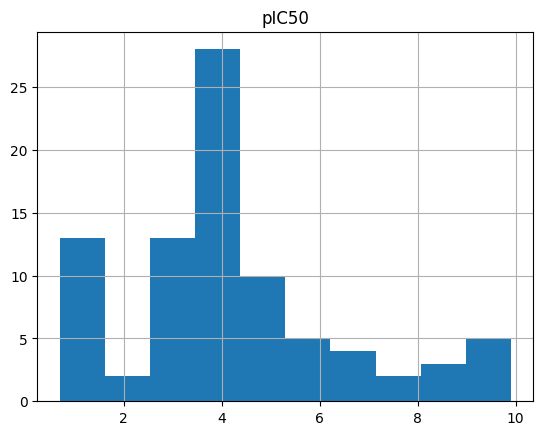

In [ ]:
output_df.hist(column="pIC50")

In [ ]:
print("the number of compounds is " + str(output_df.shape[0]))
print(' ')
print("Class blance is ")
output_df['label'].value_counts()

the number of compounds is 85
 
Class blance is 


inactive    63
active      22
Name: label, dtype: int64

In [ ]:
## This script to balnce the dataset in pos-negative samples
## it is defined in radius the proportion of majority class
## however, it only would be useful if inactives are the majority class
## and posses more samples available than the radius defined

radius=2 ## radio 1:2
actives = output_df.loc[output_df["label"] == "active", :]
num_of_actives = len(actives)

negatives = output_df.loc[output_df["label"] == "inactive", :]
sample_of_negatives = negatives.sample(int(radius)*num_of_actives)

data = pd.concat([actives, sample_of_negatives], ignore_index=True)

print("the number of compounds is " + str(data.shape[0]))
print(' ')
print("Class blance is ")
data['label'].value_counts()


the number of compounds is 66
 
Class blance is 


inactive    44
active      22
Name: label, dtype: int64